<a href="https://colab.research.google.com/github/weathon/smoke-unet/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# overlay two imgs randomly
from PIL import Image, ImageDraw, ImageFilter
import random
def overlay_imgs_randomly(forest,smoke, size):
  x = random.randint(0, size//3)
  y = random.randint(0 ,size//3)
  width = int(size * random.randint(50,120)/100)
  forest.paste(smoke.resize((width,width)), (x,y),smoke.resize((width,width)))
  return forest
  #
  #forest.paste(smoke)

In [2]:
from PIL import Image
from random import randrange
def random_crop(forest,size_matrix, target_size):
  x, y = forest.size
  x1 = randrange(0, x - size_matrix)
  y1 = randrange(120, y - size_matrix)
  return forest.crop((x1, y1, x1 + size_matrix, y1 + size_matrix)).resize((target_size,target_size))


In [3]:
import tensorflow
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
def augument(image):
  #tf.image.random_brightness(image, 0.2)
  x=random.random()
  y=random.random()
  z=random.random()
  k=random.random()

  transform = transforms.ColorJitter(
    brightness=x, contrast=y, saturation=z, hue=k)
  output_image=transform(image)
  return output_image

from PIL import Image, ImageEnhance, ImageOps
import random
def adjust_brightness_and_add_yellow_tint(img):
    #gpt
    # Open an image file
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(0.7, 1.3)  # Brightness factor between 0.7 and 1.3
    img = enhancer.enhance(factor)

    # Add a random bit of yellow
    # Yellow tint can be added by slightly increasing the Red & Green channels
    r, g, b, a = img.split()
    yellow_factor = random.randint(1, 10)  # Adjust for a slight yellow tint
    r = r.point(lambda i: i + yellow_factor)
    g = g.point(lambda i: i + yellow_factor)
    # Merge back the channels
    img = Image.merge('RGBA', (r, g, b, a))

    # Save the modified image
    return img

In [4]:
# import numpy as np
# from PIL import Image
# import pylab
# # Open the image
# image = Image.open(r"0.png")
# image = random_crop(image, 800,400)
# image2 = Image.open(r"smoke10021.png")
# image2 = adjust_brightness_and_add_yellow_tint(image2)
# image2 = overlay_imgs_randomly(Image.fromarray(np.zeros(shape=(400,400,4)).astype('uint8')),image2,400)
# image.paste(image2,(0,0),image2)
# pylab.imshow(image)
# pylab.show()
# pylab.imshow(image2.convert("L"))
# pylab.show()

In [17]:
import os
import numpy as np
def get_batch(batch_size):
  images = []
  masks = []
  for i in range(batch_size):
    image = Image.open("forest/"+random.choice(os.listdir("forest/")))
    image = random_crop(image, 800,400)
    image2 = Image.open("smoke/"+random.choice(os.listdir("smoke/")))
    image2 = adjust_brightness_and_add_yellow_tint(image2)
    image2 = overlay_imgs_randomly(Image.fromarray(np.zeros(shape=(400,400,4)).astype('uint8')),image2,400)
    image.paste(image2,(0,0),image2)
    images.append(np.array(image, dtype="float32")/255)
    masks.append(np.array(image2.convert('L'), dtype="float32")/255)
  return torch.tensor(images).permute(0,3,1,2), torch.tensor(masks).unsqueeze(-1).permute(0,3,1,2)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!cp drive/MyDrive/forest2.zip .
!cp drive/MyDrive/forest.zip .
!cp drive/MyDrive/Videos/smoke.zip .
!unzip forest2.zip -d forest2
!unzip forest.zip -d forest
!unzip smoke.zip -d smoke

Archive:  forest2.zip
replace forest2/images/38.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  forest.zip
replace forest/images/38.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  smoke.zip
replace smoke/smoke10001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
!rm smoke/*.zip

rm: cannot remove 'smoke/*.zip': No such file or directory


<ipython-input-5-e2c2e60a5c57>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(images).permute(0,3,1,2), torch.tensor(masks).unsqueeze(-1).permute(0,3,1,2)


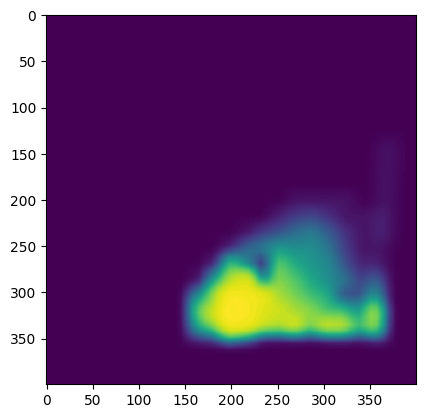

In [9]:
import pylab
pylab.imshow(get_batch(1)[1][0][0])

In [10]:
import os
for i in os.listdir("forest2"):
  os.system(f"mv forest/images/{i} forest/images/2_{i}")

In [11]:
!mv forest/*/* forest/

In [19]:
!rmdir forest/images

In [12]:
import torch, torchvision
eff = torchvision.models.efficientnet_v2_s(weights="DEFAULT")

In [13]:
class Mod(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = eff.features[:6]
    self.decoder = torch.nn.ConvTranspose2d(160,1,(32,32),16,8)

  def forward(self, x):
    return torch.nn.functional.sigmoid(self.decoder(self.encoder(x)))

1.065648078918457


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

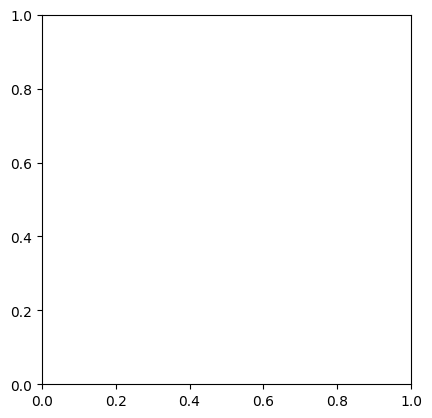

In [25]:
device = "cuda"
mod = Mod().to(device)
opt = torch.optim.Adam(mod.parameters(), 0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt,0.9)
for i in range(30):
  for j in range(1000):
    img, mask = get_batch(8)
    mod.zero_grad()
    output = mod(img.to(device))
    loss = torch.nn.functional.binary_cross_entropy(output, mask.to(device))
    print(loss.item())
    loss.backward()
    opt.step()
    if i%20==0:
      pylab.imshow(output.permute(0,2,3,1)[0].cpu())
      pylab.show()
      pylab.imshow(mask.permute(0,2,3,1)[0].cpu())
      pylab.show()
      pylab.imshow(img.permute(0,2,3,1)[0].cpu())
      pylab.show()
  scheduler.step()